In [1]:
import numpy as np
#from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
pd = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(pd[0], True)
except:
    ## GPU not found
    pass

In [3]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def showExamples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

In [4]:
def forwardNoise(x, t):
    # returns a pair of noisy images with complete noise at t=0 and non noisy image at t = timeStep
    a = timeBar[t] #baseline image 
    b = timeBar[t+1] # image at next time step
    
    noise = np.random.normal(size = x.shape) #noise mask
    
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    
    xa = x*(1-a) + noise*a
    xb = x*(1-b) + noise*b
    
    return xa, xb

def generateTimeSteps(num):
    return np.random.randint(0, timeSteps, num)

## Build model

In [5]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

def getModel(imgSize):
    x = x_input = layers.Input(shape=(imgSize, imgSize, 3), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(30 * 30 * 32)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((30, 30, 32))(x)
    
    # ----- right ( up ) -----
    #x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    #x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    #x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    #x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

In [6]:
def predict(x_idx=None):
    x = np.random.normal(size=(32, imgSize, imgSize, 3))
    for i in range(timeSteps):
        t = i
        x = diffModel.predict([x, np.full((32), t)], verbose=0)
    showExamples(x)

In [7]:
def trainOne(x):
    timeSteps = generateTimeSteps(len(x))
    xa, xb = forwardNoise(x, timeSteps)
    loss = diffModel.train_on_batch([xa, timeSteps], xb)
    return loss

### load CIFAR car data

In [8]:
#(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.cifar10.load_data()

In [9]:
'''
print(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))

#select training images that are cars
xtrain = xtrain[ytrain.squeeze()==1]

#normalize to adjust intensity between -1 and 1
xtrain = (xtrain/127.5)-1

print(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))
'''

'\nprint(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))\n\n#select training images that are cars\nxtrain = xtrain[ytrain.squeeze()==1]\n\n#normalize to adjust intensity between -1 and 1\nxtrain = (xtrain/127.5)-1\n\nprint(len(xtrain), np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))\n'

### load dandlion data

In [10]:
dand = np.load('dandelion.npy')
print(np.shape(dand))

xtrain, xtest = train_test_split(dand, test_size=0.1, random_state=45)
print(np.shape(xtrain),  np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))
xtrain = (xtrain/127.5)-1
print(np.shape(xtrain),  np.min(np.unique(xtrain)), np.max(np.unique(xtrain)))


(359, 240, 240, 3)
(323, 240, 240, 3) 0 255
(323, 240, 240, 3) -1.0 1.0


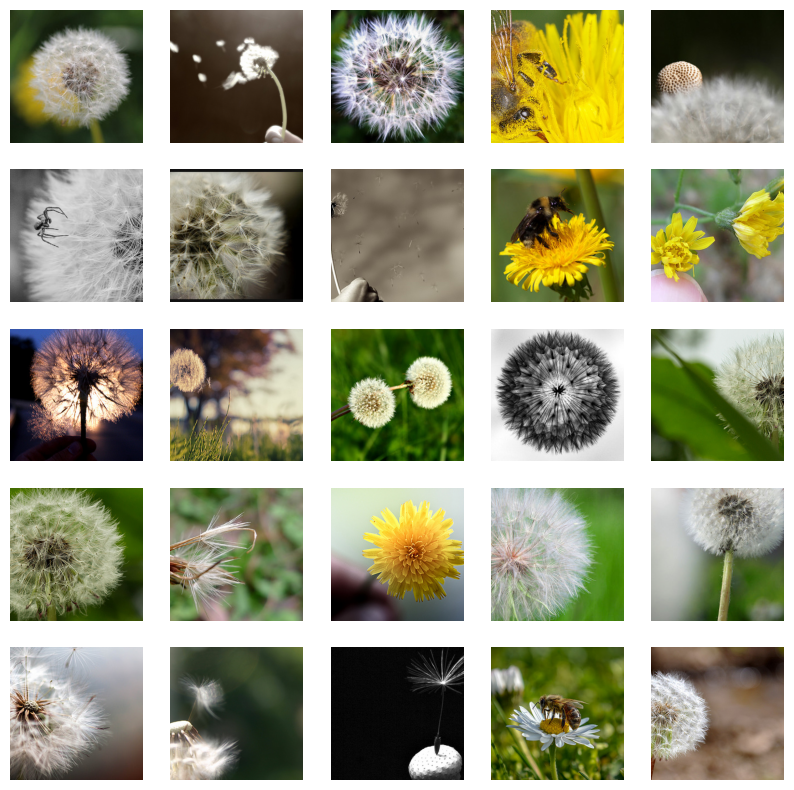

In [11]:
showExamples(xtrain)

In [12]:
# hyperparameters
imgSize = 240
batchSize = 128
epochs = 3
timeSteps = 10
timeBar = 1 - np.linspace(0,1, timeSteps + 1)


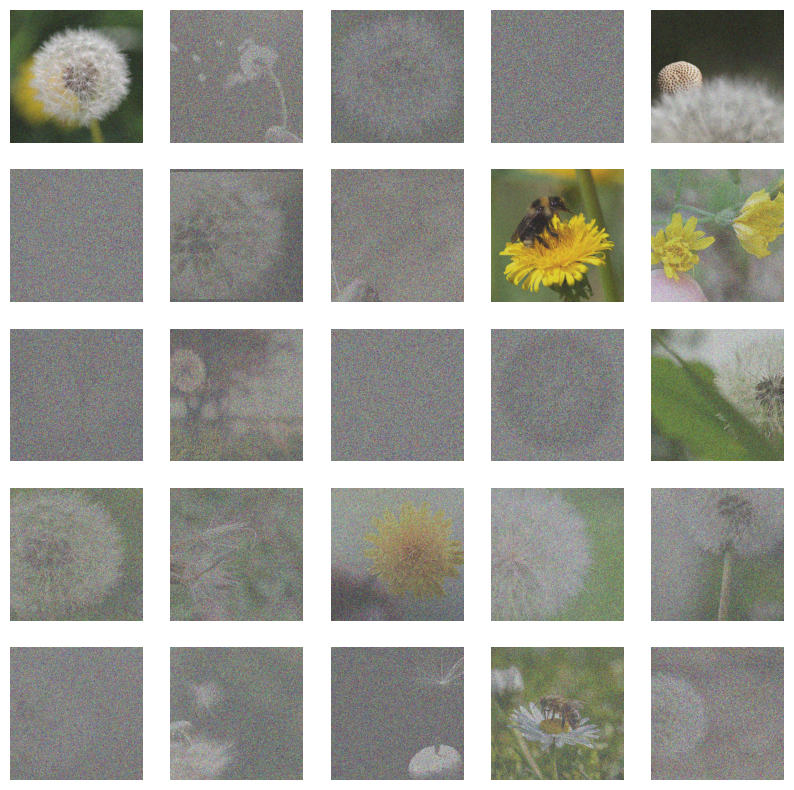

In [13]:
t = generateTimeSteps(25)
a,b = forwardNoise(xtrain[:25], t)
showExamples(a)

In [14]:
diffModel = getModel(imgSize)
diffModel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_ts_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 192)          384         ['x_ts_input[0][0]']             
                                                                                                  
 layer_normalization (LayerNorm  (None, 192)         384         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 192)          0           ['layer_normalization[0][0]']

In [15]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0008)
diffModel.compile(loss = tf.keras.losses.MeanSquaredError(),
              optimizer  = opt)

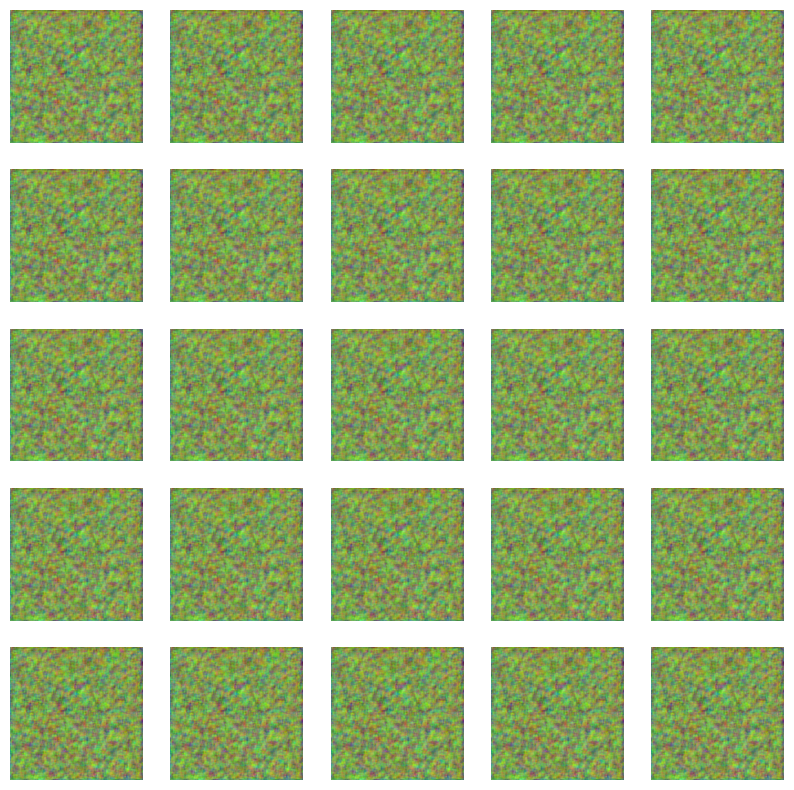

In [16]:
# this is a test prediction - the model is not trained right now so the results should be noise 
predict()

In [ ]:
b = range(50)
total = range(100)

for e in range(epochs):
    for i in b:
        for j in total:
            x = xtrain[np.random.randint(len(xtrain), size=batchSize)]
            loss = trainOne(x)

        if i%10==0:
            print("i: ", i, "\t j: ", j, "\t loss:", loss)

i:  0 	 j:  99 	 loss: 0.40447375178337097


In [ ]:
predict()